# My Model

**Goal**:  The goal of this ML project is to develop a system that can recommend similar and more affordable skincare products based on the ingredients of a given product. It should employ a machine learning model to accurately determine the similarity between products based on their ingredients.

**Movitvation**: The motivation behind the project is that when I am on holiday, I often go to drugstores or pharmacies in the respective countries and want to discover new skin care products. Sometimes I buy expensive skincare products that I would never buy in Switzerland. I have to say that I love skincare products and enjoy discovering new ones. When they run out and I like them, I want to find alternatives without wasting my time searching the internet for a similar product.The aim is to have several products as an outtput that have similar ingredients. That way I can concentrate my research on these products and then hopefully try another product. By research I mean reading up on the products, reading reviews and so on 


**Call up, check and prepare data set**

In [1]:
import pandas as pd
import numpy as np
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns





#load the data
url = "skincare_products.csv"
df = pd.read_csv(url)

#show first lines of csv file 
print(df.head())


c:\Users\goern_y\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


                                        product_name  \
0  The Ordinary Natural Moisturising Factors + HA...   
1      CeraVe Facial Moisturising Lotion SPF 25 52ml   
2  The Ordinary Hyaluronic Acid 2% + B5 Hydration...   
3          AMELIORATE Transforming Body Lotion 200ml   
4                     CeraVe Moisturising Cream 454g   

                                         product_url product_type  \
0  https://www.lookfantastic.com/the-ordinary-nat...  Moisturiser   
1  https://www.lookfantastic.com/cerave-facial-mo...  Moisturiser   
2  https://www.lookfantastic.com/the-ordinary-hya...  Moisturiser   
3  https://www.lookfantastic.com/ameliorate-trans...  Moisturiser   
4  https://www.lookfantastic.com/cerave-moisturis...  Moisturiser   

                                         ingredients   price  
0  Aqua (Water), Caprylic/Capric Triglyceride, Ce...   £5.20  
1  Aqua/Water, Homosalate, Glycerin, Octocrylene,...  £13.00  
2  Aqua (Water), Sodium Hyaluronate, Sodium Hyalu...   £6.2

In [2]:
#Inspect the types of products
display(df['product_type'].value_counts())

product_type
Mask           124
Body Wash      123
Moisturiser    115
Cleanser       115
Serum          113
Eye Care       100
Mist            80
Oil             76
Toner           73
Balm            61
Exfoliator      57
Bath Salts      36
Bath Oil        33
Peel            32
Name: count, dtype: int64

In [3]:
#Check for missing Data 

missing_values = df.isnull().sum()

missing_values = missing_values[missing_values > 0]

print(missing_values)

Series([], dtype: int64)


In [4]:
df.describe()

,product_name,product_url,product_type,ingredients,price
count,1138,1138,1138,1138,1138
unique,1138,1126,14,1090,290
top,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/lancome-advanced...,Mask,"Aqua / Water, Bifida Ferment Lysate, Glycerin,...",£22.00
freq,1,4,124,4,33


In [5]:
# Clean up the ingredients column
def preprocess_ingredients(text):
    text = text.lower()  #convert to lower case
    text = re.sub(r'[^a-z,]', '', text)  #  Remove non-letters, except commas
    ingredients = text.split(",")  # separate with commas
    ingredients = [ingredient.strip() for ingredient in ingredients]  #remove spaces
    return ingredients

df['processed_ingredients'] = df['ingredients'].apply(preprocess_ingredients)
df['ingredient_text'] = df['processed_ingredients'].apply(lambda x: ', '.join(x))

**Call up model and calculate embeddings and cosine similarity**

In [6]:
# Load model 
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)

# Function for calculating the embeddings
def get_embeddings(text):
    return model.encode(text, show_progress_bar=False)

df['embeddings'] = df['ingredient_text'].apply(get_embeddings)

# function for calculating the Cosine Similarity
embeddings = np.stack(df['embeddings'].values)
cosine_sim = cosine_similarity(embeddings)

c:\Users\goern_y\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


**Recommendation without filter**

In [7]:
# Recommendation function without filter
def recommend_products_no_filter(product_name, df, cosine_sim, top_k=10):
    try:
        idx = df[df['product_name'] == product_name].index[0]
    except IndexError:
        return "Produktname nicht gefunden."

    #Calculate and sort similarity values 
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # return recommended products
    recommended_indices = [i[0] for i in sim_scores if i[0] != idx][:top_k]
    recommended_cosine_similarities = [i[1] for i in sim_scores if i[0] != idx][:top_k]

    recommended_products = df.loc[recommended_indices, ['product_name', 'product_url', 'product_type', 'price']]
    recommended_products['cosine_similarity'] = recommended_cosine_similarities

    return recommended_products

# Recommendation function without filter is called 
recommendations_no_filter = recommend_products_no_filter("The Ordinary Natural Moisturising Factors + HA 30ml", df, cosine_sim)

#format output
def format_output(): 
    pd.set_option('display.max_rows', None)  
    pd.set_option('display.max_columns', None)  
    pd.set_option('display.width', 1000)  
    pd.set_option('display.colheader_justify', 'left') 
    pd.set_option('display.precision', 6) 

print("Recommendations without filter based on cosine similarity:")
print(recommendations_no_filter)

Recommendations without filter based on cosine similarity:
                                          product_name  \
7    The Ordinary Natural Moisturizing Factors + HA...   
145                      The Ordinary Amino Acids + B5   
702                    CeraVe Hydrating Cleanser 473ml   
704               CeraVe Foaming Facial Cleanser 473ml   
322  Lumene Nordic Hydra [Lähde] Arctic Spring Wate...   
355    Zelens PROVITAMIN D Fortifying Facial Mist 50ml   
701                    CeraVe Hydrating Cleanser 236ml   
315  Lumene Nordic Hydra Lähde Arctic Spring Water ...   
5                     CeraVe Moisturising Lotion 473ml   
643  Lumene Nordic Hydra [Lähde] Purity Dew Drops H...   

                                           product_url product_type   price  \
7    https://www.lookfantastic.com/the-ordinary-nat...  Moisturiser   £6.80   
145  https://www.lookfantastic.com/the-ordinary-ami...        Serum   £5.90   
702  https://www.lookfantastic.com/cerave-hydrating...     Cleans

**Recommendation function with product type filter** This function is useful if I only want to have recommendations of products of the same type listed

In [8]:
# Recommendation funciton with product type filter
def recommend_products_type_filter(product_name, df, cosine_sim, top_k=30):
    recommendations = recommend_products_no_filter(product_name, df, cosine_sim, top_k * 2)  # Erhöhe top_k, um genügend Kandidaten zu haben
    original_type = df.loc[df['product_name'] == product_name, 'product_type'].values[0]
    filtered_recommendations = recommendations[recommendations['product_type'] == original_type][:top_k]
    return filtered_recommendations

#Call up the recommendation function with product type filter 
recommendations_type_filter = recommend_products_type_filter("The Ordinary Natural Moisturising Factors + HA 30ml", df, cosine_sim)
print("Recommendations with product type filter:")
print(recommendations_type_filter)


Recommendations with product type filter:
                                          product_name  \
7    The Ordinary Natural Moisturizing Factors + HA...   
5                     CeraVe Moisturising Lotion 473ml   
98   Fade Out ADVANCED + Age Protection Even Skin T...   
94   Fade Out ADVANCED Even Skin Tone Day Cream SPF...   
1        CeraVe Facial Moisturising Lotion SPF 25 52ml   
40           La Roche-Posay Nutritic Intense Rich 50ml   
58        The INKEY List Multi-Biotic Moisturiser 30ml   
22          La Roche-Posay Effaclar H Moisturiser 40ml   
72                 Bulldog Sensitive Moisturiser 100ml   
76   Fade Out ADVANCED Even Skin Tone Night Cream 50ml   
6        CeraVe Facial Moisturising Lotion No SPF 52ml   
36   La Roche-Posay Effaclar K(+) Anti-Blackhead Mo...   
103                        Liz Earle Skin Repair Light   

                                           product_url product_type   price  \
7    https://www.lookfantastic.com/the-ordinary-nat...  Moisturise

**Recommendation function with price and product type filter**. Please note that the product input is also listed in the output. Here the cosine similartiy is set to 1.0. The additional output of the input helps to see whether products that are really the same or cheaper than the input are suggested 

In [9]:
# Recommendation function with price and product type filter
def recommend_products_price_and_type_filter(product_name, df, cosine_sim, top_k=30):
    recommendations = recommend_products_no_filter(product_name, df, cosine_sim, top_k * 2)  # Erhöhe top_k, um genügend Kandidaten zu haben
    original_price = float(df.loc[df['product_name'] == product_name, 'price'].values[0].replace('£', ''))
    original_type = df.loc[df['product_name'] == product_name, 'product_type'].values[0]
    filtered_recommendations = recommendations[(recommendations['product_type'] == original_type) & 
                                               (recommendations['price'].str.replace('£', '').astype(float) <= original_price)][:top_k]
    # Add the entered product to the list of recommendations
    input_product = df[df['product_name'] == product_name][['product_name', 'product_url', 'product_type', 'price']]
    input_product['cosine_similarity'] = 1.0  #Set the cosine similarity to 1.0 for the input product
    combined_recommendations = pd.concat([input_product, filtered_recommendations])
    return combined_recommendations

#Calling up the recommendation function with price and product type filter
recommendations_price_and_type_filter = recommend_products_price_and_type_filter("The Ordinary Natural Moisturising Factors + HA 30ml", df, cosine_sim)
print("Recommendation with price and product type filter:")
print(recommendations_price_and_type_filter)



Recommendation with price and product type filter:
                                         product_name  \
0   The Ordinary Natural Moisturising Factors + HA...   
72                Bulldog Sensitive Moisturiser 100ml   

                                          product_url product_type  price  \
0   https://www.lookfantastic.com/the-ordinary-nat...  Moisturiser  £5.20   
72  https://www.lookfantastic.com/bulldog-sensitiv...  Moisturiser  £4.50   

    cosine_similarity  
0             1.00000  
72            0.90509  


## Visualisierung: 

### Visualisation Cosine Similarty



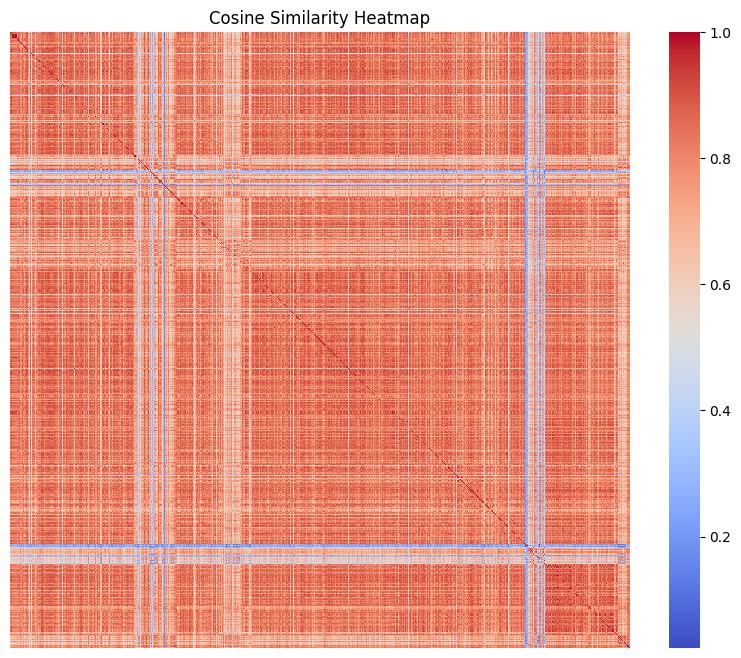

In [10]:
# Visualize the Cosine Similarity as a Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim, annot=False, cmap='coolwarm', xticklabels=False, yticklabels=False)
plt.title("Cosine Similarity Heatmap")
plt.show()

**Interpretation**: 

Here, the cosine similarity is shown from the cleaned dataset and not from the recommendation functions. The red area in the heatmap shows a relatively high cosine similarity value (close to 1). This means that the corresponding embeddings are very similar. This is not a big surprise, as many ingredients of facial care products are sometimes quite similar in structure. For example, it is often the case that one of the first ingredients in a moisturiser is water. Most moisterisers are water-based. Serums, toners and ampoules, for example, are mostly water-based. 

Basically, however, it shows that there is a similarity in my data. Which is a good sign for my intended use. 

### Visualistion of the cosine similarity of the recommended products

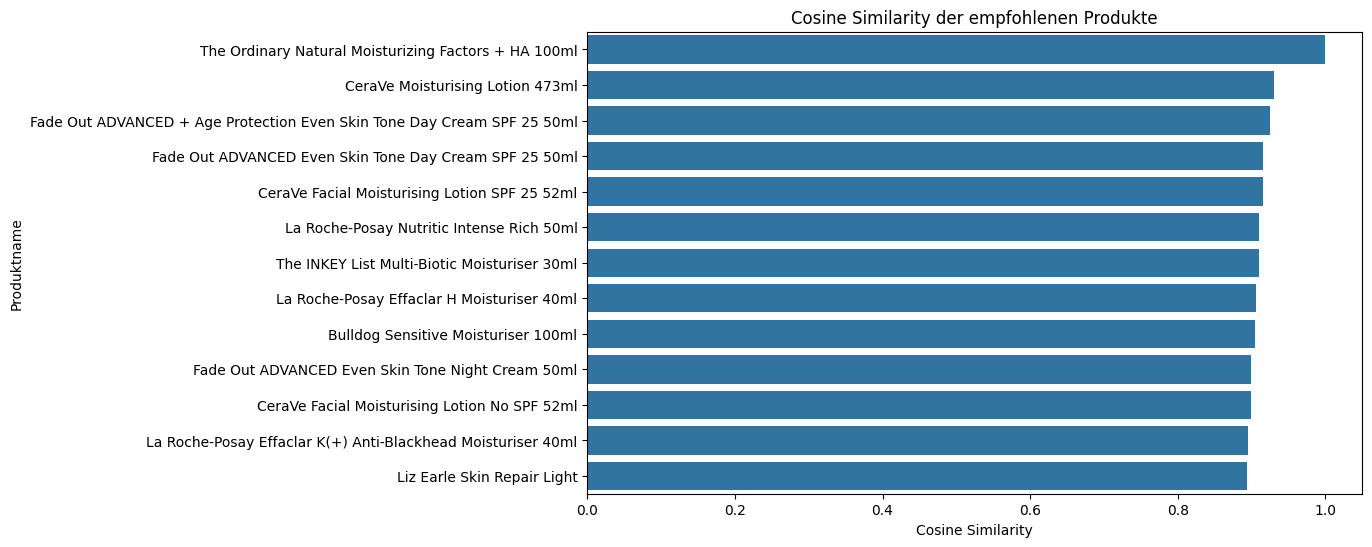

In [11]:
# Function for visualising the cosine similarity of the recommended products
def plot_cosine_similarity(recommended_products):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='cosine_similarity', y='product_name', data=recommended_products)
    plt.title('Cosine Similarity der empfohlenen Produkte')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Produktname')
    plt.show()

# Calling the function 
plot_cosine_similarity(recommendations_type_filter)





**Interpretaion**: 

The cosine similarty of the recommended products is shown here in a bar chart. The distance between the individual products can be seen. 



### 2D Visualition of the embeddings:

This allows me to see at a glance which embeddings (and therefore which products) are similar and which are not. 


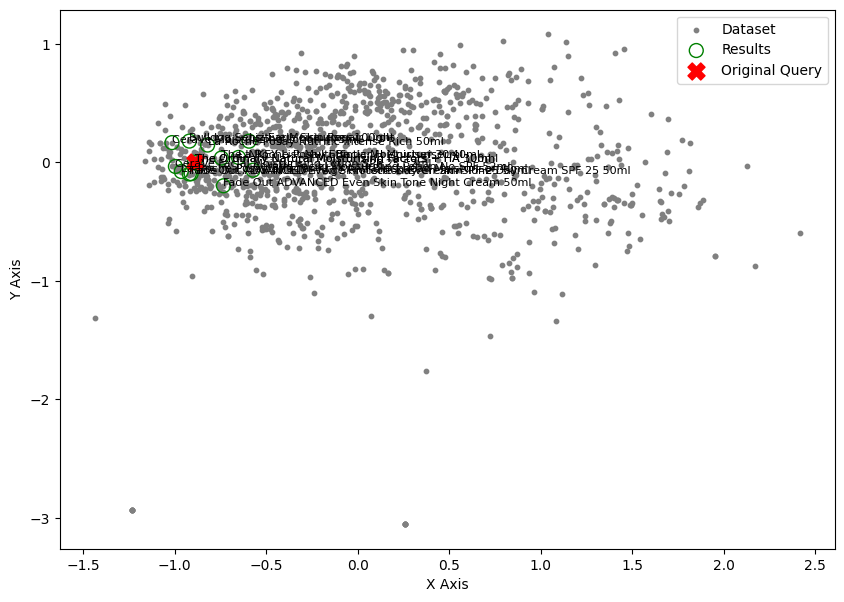

In [12]:
# PCA for 2D projection
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)
df['pca_embedding'] = pca_embeddings.tolist()

# 2D visualisation of the embeddings
def plot_2d_embeddings(df, recommended_products, original_product):
    plt.figure(figsize=(10, 7))
    
    # All embeddings
    all_embeddings = np.array(df['pca_embedding'].tolist())
    plt.scatter(all_embeddings[:, 0], all_embeddings[:, 1], s=10, color='gray', label='Dataset')

    # Recommended products
    recommended_embeddings = np.array([df.loc[df['product_name'] == name, 'pca_embedding'].values[0] for name in recommended_products['product_name']])
    plt.scatter(recommended_embeddings[:, 0], recommended_embeddings[:, 1], s=100, facecolors='none', edgecolors='g', label='Results')

    # Original query product
    original_embedding = df.loc[df['product_name'] == original_product, 'pca_embedding'].values[0]
    plt.scatter(original_embedding[0], original_embedding[1], s=150, marker='X', color='r', label='Original Query')

    # Annotations for recommended products
    for i, text in enumerate(recommended_products['product_name']):
        plt.annotate(text, (recommended_embeddings[i, 0], recommended_embeddings[i, 1]), fontsize=8)

    plt.annotate(original_product, (original_embedding[0], original_embedding[1]), fontsize=8)
    
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.legend()
    plt.show()

# 2D-Visulisation
plot_2d_embeddings(df, recommendations_type_filter, "The Ordinary Natural Moisturising Factors + HA 30ml")


**Interpretation:**

It can be seen that some recommendations are not close to the input product. There are products that are much closer to the input than the suggested products in my model. This indicates that my model is still in need of improvement. 

### Conclusion: 

The visualisations show that the cleansed data set has similar texts. However, the actual recommendations are often not the most similar products (see last visualisation). This indicates that there is still room for improvement. 

## More Examples 

### Example: Estée Lauder DayWear Advanced Multi-Protection Anti-Oxidant Creme SPF15 N/C 50ml

In [13]:
# Test the recommendation function with price and product type filter
recommendations_no_filter = recommend_products_no_filter("Estée Lauder DayWear Advanced Multi-Protection Anti-Oxidant Creme SPF15 N/C 50ml", df, cosine_sim)
format_output()
print("Recommendations without filter:")
print(recommendations_no_filter)



Recommendations without filter:
    product_name                                       product_url                                        product_type price     cosine_similarity
42   Estée Lauder DayWear Multi-Protection Anti-Oxi...  https://www.lookfantastic.com/estee-lauder-day...  Moisturiser   £25.20  1.000000         
109  Clinique Smart SPF 15 Custom Repair Moisturise...  https://www.lookfantastic.com/clinique-smart-s...  Moisturiser   £52.00  0.950047         
994  Jo Malone London Lime Basil and Mandarin Soap ...  https://www.lookfantastic.com/jo-malone-london...    Body Wash   £16.00  0.940660         
87   Clinique Moisture Surge SPF25 Sheertint Hydrat...  https://www.lookfantastic.com/clinique-moistur...  Moisturiser   £30.00  0.940389         
165  Clinique Repairwear Laser Focus Smooths, Resto...  https://www.lookfantastic.com/clinique-repairw...        Serum   £47.00  0.931007         
458              NARS Cosmetics Aqua Gel Luminous Mask  https://www.lookfantastic.com/

In [14]:
# Recommendation function with price and product type filter
recommendations_price_and_type_filter = recommend_products_price_and_type_filter("Estée Lauder DayWear Advanced Multi-Protection Anti-Oxidant Creme SPF15 N/C 50ml", df, cosine_sim)
format_output()
print("Recommendations with price and product type filter:")
print(recommendations_price_and_type_filter)

Recommendations with price and product type filter:
    product_name                                       product_url                                        product_type price    cosine_similarity
28   Estée Lauder DayWear Advanced Multi-Protection...  https://www.lookfantastic.com/estee-lauder-day...  Moisturiser  £40.50  1.000000         
42   Estée Lauder DayWear Multi-Protection Anti-Oxi...  https://www.lookfantastic.com/estee-lauder-day...  Moisturiser  £25.20  1.000000         
87   Clinique Moisture Surge SPF25 Sheertint Hydrat...  https://www.lookfantastic.com/clinique-moistur...  Moisturiser  £30.00  0.940389         
79   Clinique Moisture Surge Intense Skin Fortifyin...  https://www.lookfantastic.com/clinique-moistur...  Moisturiser  £37.00  0.908970         
92      Clinique for Men Oil-Control Moisturiser 100ml  https://www.lookfantastic.com/clinique-for-men...  Moisturiser  £25.50  0.907406         
105  Murad Oil and Pore Control Mattifier SPF45 PA ...  https://www.look

### Example: Sanctuary Spa 10-in-1 Super Secret Facial Oil 30ml

In [16]:
# Recommendation function no filter
recommendations_no_filter = recommend_products_no_filter("Sanctuary Spa 10-in-1 Super Secret Facial Oil 30ml", df, cosine_sim)

print("Recommendations without filter:")
print(recommendations_no_filter)

Recommendations without filter:
     product_name                                       product_url                                        product_type price    cosine_similarity
1114       Neal's Yard Remedies Soothing Bath Oil 100ml  https://www.lookfantastic.com/neal-s-yard-reme...   Bath Oil    £15.00  0.902128         
1032                   REN Moroccan Rose Otto Body Wash  https://www.lookfantastic.com/ren-clean-skinca...  Body Wash    £20.00  0.883163         
244                    Elemis Superfood Facial Oil 15ml  https://www.lookfantastic.com/elemis-superfood...        Oil    £45.00  0.880082         
265         Sanctuary Spa Melt Away Cleansing Oil 150ml  https://www.lookfantastic.com/sanctuary-spa-me...        Oil    £12.00  0.878400         
867                        MÁDARA Balancing Toner 200ml  https://www.lookfantastic.com/madara-balancing...      Toner    £17.00  0.868080         
258                  BBB London Luscious Lash Oil 7.5ml  https://www.lookfantastic.com

In [19]:
# Recommendation function with price and product type filter
recommendations_price_and_type_filter = recommend_products_price_and_type_filter("Sanctuary Spa 10-in-1 Super Secret Facial Oil 30ml", df, cosine_sim)
format_output()
print("Recommendations with price and product type filter:")
print(recommendations_price_and_type_filter)

Recommendations with price and product type filter:
    product_name                                       product_url                                        product_type price    cosine_similarity
262  Sanctuary Spa 10-in-1 Super Secret Facial Oil ...  https://www.lookfantastic.com/sanctuary-spa-10...  Oil          £20.00  1.000000         
265        Sanctuary Spa Melt Away Cleansing Oil 150ml  https://www.lookfantastic.com/sanctuary-spa-me...  Oil          £12.00  0.878400         
270  Sanctuary Spa Overnight Replenishing Miracle O...  https://www.lookfantastic.com/sanctuary-spa-ov...  Oil          £20.00  0.845609         
282          AromaWorks Rejuvenate Face Serum Oil 30ml  https://www.lookfantastic.com/aromaworks-rejuv...  Oil          £14.99  0.831310         


## Example: REN Moroccan Rose Otto Body Wash

In [20]:
# Recommendation function with price and product type filter
recommendations_no_filter = recommend_products_no_filter("REN Moroccan Rose Otto Body Wash", df, cosine_sim)

print("Recommendations without filter:")
print(recommendations_no_filter)

Recommendations without filter:
    product_name                                       product_url                                        product_type price     cosine_similarity
218  DECLÉOR Hydra Floral White Petal Skin Perfecti...  https://www.lookfantastic.com/decleor-hydra-fl...       Serum    £36.40  0.922025         
903           Origins Modern Friction™ Exfoliator 75ml  https://www.lookfantastic.com/origins-modern-f...  Exfoliator    £27.00  0.915421         
552           Chantecaille Jasmine & Lily Healing Mask  https://www.lookfantastic.com/chantecaille-jas...        Mask    £75.00  0.912902         
737   REN Clean Skincare Rosa Centifolia Cleansing Gel  https://www.lookfantastic.com/ren-clean-skinca...    Cleanser    £18.00  0.912824         
518                  Chantecaille Bio Lift Mask - 50ml  https://www.lookfantastic.com/chantecaille-bio...        Mask   £148.00  0.909249         
637  REN Clean Skincare Keep Young and Beautiful Fi...  https://www.lookfantastic.com/

In [21]:
# Recommendation function with price and product type filter
recommendations_price_and_type_filter = recommend_products_price_and_type_filter("REN Moroccan Rose Otto Body Wash", df, cosine_sim)
format_output()
print("Recommendations with price and product type filter:")
print(recommendations_price_and_type_filter)

Recommendations with price and product type filter:
     product_name                                    product_url                                        product_type price    cosine_similarity
1032                REN Moroccan Rose Otto Body Wash  https://www.lookfantastic.com/ren-clean-skinca...  Body Wash    £20.00  1.000000         
998                Sukin Botanical Body Wash (500ml)  https://www.lookfantastic.com/sukin-botanical-...  Body Wash     £9.95  0.894587         
1066  Sukin Botanical Lime & Coconut Body Wash 500ml  https://www.lookfantastic.com/sukin-botanical-...  Body Wash     £9.95  0.885798         
1085        this works Deep Sleep Shower Gel (250ml)  https://www.lookfantastic.com/this-works-deep-...  Body Wash    £18.00  0.861248         


### Example: Elemis Dynamic Resurfacing Facial Wash 200ml

In [22]:
# Recommendation function with price and product type filter
recommendations_no_filter = recommend_products_no_filter("Elemis Dynamic Resurfacing Facial Wash 200ml", df, cosine_sim)

print("Recommendations without filter:")
print(recommendations_no_filter)

Recommendations without filter:
     product_name                                       product_url                                        product_type price    cosine_similarity
726               Elemis Superfood Cleansing Wash 150ml  https://www.lookfantastic.com/elemis-superfood...     Cleanser  £25.00  0.985639         
88            The INKEY List Bakuchiol Moisturiser 30ml  https://www.lookfantastic.com/the-inkey-list-b...  Moisturiser   £9.99  0.957678         
1007  La Roche-Posay Lipikar Syndet AP(+) Shower Gel...  https://www.lookfantastic.com/la-roche-posay-l...    Body Wash  £16.50  0.953822         
213   FOREO 'Serum Serum Serum' Micro-Capsule Youth ...  https://www.lookfantastic.com/foreo-serum-seru...        Serum  £49.00  0.952629         
113                    Bioderma Hydrabio Gel Cream 40ml  https://www.lookfantastic.com/bioderma-hydrabi...  Moisturiser  £15.20  0.951857         
1022                  Bioderma Atoderm Shower Oil 200ml  https://www.lookfantastic.com

In [23]:
# Recommendation function with price and product type filter
recommendations_price_and_type_filter = recommend_products_price_and_type_filter("Elemis Dynamic Resurfacing Facial Wash 200ml", df, cosine_sim)
format_output()
print("Recommendations with price and product type filter:")
print(recommendations_price_and_type_filter)

Recommendations with price and product type filter:
    product_name                                       product_url                                        product_type price    cosine_similarity
715       Elemis Dynamic Resurfacing Facial Wash 200ml  https://www.lookfantastic.com/elemis-dynamic-r...  Cleanser     £34.00  1.000000         
726              Elemis Superfood Cleansing Wash 150ml  https://www.lookfantastic.com/elemis-superfood...  Cleanser     £25.00  0.985639         
769  Lancôme Crème Mousse Confort Creamy Foaming Cl...  https://www.lookfantastic.com/lancome-creme-mo...  Cleanser     £22.50  0.950479         
704               CeraVe Foaming Facial Cleanser 473ml  https://www.lookfantastic.com/cerave-foaming-f...  Cleanser     £15.00  0.946693         
743   philosophy Purity One-Step Facial Cleanser 480ml  https://www.lookfantastic.com/philosophy-purit...  Cleanser     £30.00  0.942088         
723    Neutrogena Hydro Boost Water Gel Cleanser 200ml  https://www.look

## Metrics



In [24]:
import numpy as np
import pandas as pd

# Metric calculation functions
def precision_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    relevant_and_recommended = set(recommended_at_k) & relevant_items
    return len(relevant_and_recommended) / k

def recall_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    relevant_and_recommended = set(recommended_at_k) & relevant_items
    return len(relevant_and_recommended) / len(relevant_items)

def f1_score_at_k(recommended_items, relevant_items, k):
    precision = precision_at_k(recommended_items, relevant_items, k)
    recall = recall_at_k(recommended_items, relevant_items, k)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Recommendation function without filter
def recommend_products_no_filter(product_name, df, cosine_sim, top_k=10):
    try:
        idx = df[df['product_name'] == product_name].index[0]
    except IndexError:
        return []

    # Calculate and sort similarity values 
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Return recommended products
    recommended_indices = [i[0] for i in sim_scores if i[0] != idx][:top_k]
    recommended_products = df.loc[recommended_indices, 'product_name'].tolist()
    
    return recommended_products

# Recommendation function with price and product type filter
def recommend_products_price_and_type_filter(product_name, df, cosine_sim, top_k=30):
    recommendations = recommend_products_no_filter(product_name, df, cosine_sim, top_k * 2)  
    original_price = float(df.loc[df['product_name'] == product_name, 'price'].values[0].replace('£', ''))
    original_type = df.loc[df['product_name'] == product_name, 'product_type'].values[0]
    filtered_recommendations = df[df['product_name'].isin(recommendations)]
    filtered_recommendations = filtered_recommendations[(filtered_recommendations['product_type'] == original_type) & 
                                                        (filtered_recommendations['price'].str.replace('£', '').astype(float) <= original_price)][:top_k]
    return filtered_recommendations

# Evaluating the model's performance
def evaluate_model(df, cosine_sim, k_values=[5, 10, 20]):
    precision_scores = {k: [] for k in k_values}
    recall_scores = {k: [] for k in k_values}
    f1_scores = {k: [] for k in k_values}

    for product_name in df['product_name']:
        relevant_items = set(df[df['product_type'] == df.loc[df['product_name'] == product_name, 'product_type'].values[0]]['product_name']) - {product_name}

        for k in k_values:
            recommended_items = recommend_products_price_and_type_filter(product_name, df, cosine_sim, k)
            recommended_product_names = recommended_items['product_name'].tolist()
            
            if len(recommended_product_names) == 0:
                continue

            precision = precision_at_k(recommended_product_names, relevant_items, k)
            recall = recall_at_k(recommended_product_names, relevant_items, k)
            f1 = f1_score_at_k(recommended_product_names, relevant_items, k)

            precision_scores[k].append(precision)
            recall_scores[k].append(recall)
            f1_scores[k].append(f1)
    
    avg_precision = {k: np.mean(precision_scores[k]) for k in k_values}
    avg_recall = {k: np.mean(recall_scores[k]) for k in k_values}
    avg_f1 = {k: np.mean(f1_scores[k]) for k in k_values}
    
    return avg_precision, avg_recall, avg_f1

# Evaluate the model
k_values = [5, 10, 20]
avg_precision, avg_recall, avg_f1 = evaluate_model(df, cosine_sim, k_values)

for k in k_values:
    print(f'Average Precision@{k}: {avg_precision[k]:.2f}')
    print(f'Average Recall@{k}: {avg_recall[k]:.2f}')
    print(f'Average F1-Score@{k}: {avg_f1[k]:.2f}')


Average Precision@5: 0.47
Average Recall@5: 0.03
Average F1-Score@5: 0.05
Average Precision@10: 0.33
Average Recall@10: 0.04
Average F1-Score@10: 0.07
Average Precision@20: 0.25
Average Recall@20: 0.06
Average F1-Score@20: 0.09


## Interpretation: 

**Precision@5**: How many of the top 5 recommendations are relevant?

**Recall@5**: How many of the relevant products were found in the top 5 recommendations?

**F1-Score@5:** A combined metric that takes into account both precision and recall.


**Precision: 0.47, 0.33, 0.25** -> Precision decreases as kk increases, which is expected as it becomes more difficult to find more relevant articles among the top kk. The precision values of 0.47, 0.33 and 0.25 are acceptable, but there is room for improvement.
**Recall: 0.03, 0.04, 0.06** -> The recall values are very low overall. This means that the model has difficulty finding a large number of relevant articles, which indicates that many relevant articles do not appear among the top kk recommendations.
**F1-Score: 0.05, 0.07, 0.09** The F1 scores are also low, which is a consequence of the low recall values. This indicates that the model needs to be improved in terms of both precision and recall.

My model has moderate precision but very low recall values, resulting in low F1 scores overall. This means that my model is able to find some relevant articles, but it does not find enough relevant articles to achieve a high overall performance. My model needs to be improved. 


## Benchmarking

I would like to compare my model with another model. I have selected a similar project from GitHub for comparison.

Here is the link to the original GitHub project: https://github.com/rosagradilla19/skincare-products-recommendation-system/tree/main 

Here is the GitHub with adjustments: https://github.com/goernjosi/VergleichModel 


### My Steps:

1. Clone the repository.
2. Check if the same products are available (see code below).
3. The dataset was not the same, so I replaced it with my own dataset. For this, I had to adjust the code. 
4. Then I tested both models with the same product: The Ordinary Natural Moisturising Factors + HA 30ml.
5. Compare the test results.
6. Calculate the same metrics for both models and compare them.

### How do the two models differ?

- Other model: based on t-SNE
- My model: Transformer

The two models differ in their approach to dimensionality reduction and similarity calculation. While the t-SNE model is based on Euclidean distances in the reduced space, the Transformer model uses pre-trained embeddings and cosine similarity.


### Results of the matrices summarised
**t-SNE**
- **Precision (0.10)**: Very low. Only 10% of the recommended products are relevant.
- **Recall (1.00):** Extremely high, meaning that all relevant products were found. However, this could indicate that many irrelevant products are also recommended.
- **F1 score (0.18):** Low, showing a poor balance between Precision and Recall.
Has an extremely high recall, which indicates that it finds all relevant products. However, the precision is very low, which means that many irrelevant products are also recommended. The F1 score shows that the balance between precision and recall is poor.

**my Model**
- **PRecision (0.47, 0.33, 0.25)**: moderate to low
- **Recall (0.03, 0.04, 0.06)**: low
- **F+ score (0.05, 0.07, 0.09)**: generally very low

Shows better precision, especially for smaller kk values (top 5 and top 10), which means that the recommended products are more often relevant. However, the recall is very low, indicating that the model misses many relevant products. The F1 score shows that the model needs to be improved in overall performance. 



### Conclusion:

Overall, the other model performs better than mine. My model needs to be fine-tuned to achieve improved performance.

However, since the other project was part of a master's thesis, I am relatively satisfied with my project.

## Review of joint products 

Here it was checked whether the two data sets have the same products. It was found that the two data sets do not have any data points in common. I therefore had to retrain the comparison model with my data set. I did this so that I can compare the two models with the same products and see which performance is better.  

In [ ]:
import pandas as pd

# Load CSV files
df1 = pd.read_csv('cosmetics.csv')
df2 = pd.read_csv('skincare_products.csv')

# 'product_name' is the column in the first CSV and 'Name' is the column in the second CSV
product_names_1 = df1['Name'].str.lower().str.strip()
product_names_2 = df2['product_name'].str.lower().str.strip()

# Find common products
common_products = set(product_names_1) & set(product_names_2)

print(f"Number of common products: {len(common_products)}")
print("Common products:")
for product in common_products:
    print(product)


Number of common products: 0
Common products:


## Other Modell

Here I have only added the most important elements for the comparison. I have added the code here to make it easier to compare the two models.

Here is the github link aganin: https://github.com/rosagradilla19/skincare-products-recommendation-system

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE 
from scipy.spatial.distance import cdist

# Load the data
df3 = pd.read_csv("skincare_products.csv")


# Filter for Moisturiser
moisturizers = df3[df3['product_type'] == 'Moisturiser']

# Reset index
moisturizers_subset = moisturizers.reset_index(drop=True)

# Show result
print(moisturizers_subset)


# Initialize dictionary, list, and initial index
ingredient_idx = {}
corpus = []
idx = 0

# For loop for tokenization
for i in range(len(moisturizers_subset)):    
    ingredients = moisturizers_subset['ingredients'][i]
    ingredients_lower = ingredients.lower()
    tokens = ingredients_lower.split(', ')
    corpus.append(tokens)
    for ingredient in tokens:
        if ingredient not in ingredient_idx:
            ingredient_idx[ingredient] = idx
            idx += 1

# Get the number of items and tokens 
M = len(moisturizers_subset)
N = len(ingredient_idx)

# Initialize a matrix of zeros
A = np.zeros((M,N))


# Define the oh_encoder function
def oh_encoder(tokens):
    x = np.zeros(N)
    for ingredient in tokens:
        # Get the index for each ingredient
        idx = ingredient_idx[ingredient]
        # Put 1 at the corresponding indices
        x[idx] = 1
    return x


# Make a document-term matrix
i = 0
for tokens in corpus:
    A[i, :] = oh_encoder(tokens)
    i +=1

            
# Dimension reduction with t-SNE
model = TSNE(n_components = 2, learning_rate = 200, random_state = 42)
tsne_features = model.fit_transform(A)

# Make X, Y columns 
moisturizers_subset['X'] = tsne_features[:, 0]
moisturizers_subset['Y'] = tsne_features[:, 1]

# Find similar products -> same product as selected in my model
target = moisturizers_subset[moisturizers_subset['product_name'] == 'The Ordinary Natural Moisturising Factors + HA 30ml']
target

x  = target['X'].values[0]
y = target['Y'].values[0]
print(x, y)


df4 = pd.DataFrame()
df4['point'] = [(x, y) for x,y in zip(moisturizers_subset['X'], moisturizers_subset['Y'])]

df4.head()

point = np.array([[x,y]])

point.shape

moisturizers_subset['distance'] = [cdist(np.array([[x,y]]), np.array([product]), metric='euclidean') for product in df4['point']]

# arrange by descending order
top_matches = moisturizers_subset.sort_values(by=['distance'])
recommendations_tsne = top_matches.head(5)

print("t-SNE Recommendations:")
print(recommendations_tsne)


    product_name                                       product_url                                        product_type ingredients                                        price   
0    The Ordinary Natural Moisturising Factors + HA...  https://www.lookfantastic.com/the-ordinary-nat...  Moisturiser  Aqua (Water), Caprylic/Capric Triglyceride, Ce...    £5.20
1        CeraVe Facial Moisturising Lotion SPF 25 52ml  https://www.lookfantastic.com/cerave-facial-mo...  Moisturiser  Aqua/Water, Homosalate, Glycerin, Octocrylene,...   £13.00
2    The Ordinary Hyaluronic Acid 2% + B5 Hydration...  https://www.lookfantastic.com/the-ordinary-hya...  Moisturiser  Aqua (Water), Sodium Hyaluronate, Sodium Hyalu...    £6.20
3            AMELIORATE Transforming Body Lotion 200ml  https://www.lookfantastic.com/ameliorate-trans...  Moisturiser  Aqua/Water/Eau, Ammonium Lactate, C12-15 Alkyl...   £22.50
4                       CeraVe Moisturising Cream 454g  https://www.lookfantastic.com/cerave-moisturis...

### Matrics for the other modell

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Calculation of metrics
def calculate_metrics(true_labels, recommended_indices, total_items):
    y_true = np.zeros(total_items)
    y_true[true_labels] = 1

    y_pred = np.zeros(total_items)
    y_pred[recommended_indices] = 1

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return precision, recall, f1

# Simulated true labels for evaluation
true_labels = [0]  # Index of the actual similar product

# Indices of recommended products
recommended_indices_tsne = recommendations_tsne.index.tolist()

# Total number of products
total_items = len(moisturizers_subset)

# Calculation of metrics for t-SNE
precision_tsne, recall_tsne, f1_tsne = calculate_metrics(true_labels, recommended_indices_tsne, total_items)

print("t-SNE Recommendations Metrics:")
print(f"Precision: {precision_tsne:.2f}")
print(f"Recall: {recall_tsne:.2f}")
print(f"F1-Score: {f1_tsne:.2f}")


t-SNE Recommendations Metrics:
Precision: 0.20
Recall: 1.00
F1-Score: 0.33


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Metric calculation functions
def precision_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    relevant_and_recommended = set(recommended_at_k) & relevant_items
    return len(relevant_and_recommended) / k

def recall_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    relevant_and_recommended = set(recommended_at_k) & relevant_items
    return len(relevant_and_recommended) / len(relevant_items)

def f1_score_at_k(recommended_items, relevant_items, k):
    precision = precision_at_k(recommended_items, relevant_items, k)
    recall = recall_at_k(recommended_items, relevant_items, k)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Calculate metrics function
def calculate_metrics(true_labels, recommended_indices, total_items):
    y_true = np.zeros(total_items)
    y_true[true_labels] = 1

    y_pred = np.zeros(total_items)
    y_pred[recommended_indices] = 1

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return precision, recall, f1

# Recommendation function using t-SNE
def recommend_products_tsne(product_name, df, top_k=10):
    target = df[df['product_name'] == product_name]
    if target.empty:
        return pd.DataFrame()

    x = target['X'].values[0]
    y = target['Y'].values[0]

    df4 = pd.DataFrame()
    df4['point'] = [(x, y) for x, y in zip(df['X'], df['Y'])]
    df['distance'] = [cdist(np.array([[x, y]]), np.array([product]), metric='euclidean') for product in df4['point']]

    top_matches = df.sort_values(by=['distance']).head(top_k)
    return top_matches

# Evaluation function for the t-SNE model
def evaluate_model_tsne(df, top_k=10):
    precision_scores = []
    recall_scores = []
    f1_scores = []

    total_items = len(df)

    for index, row in df.iterrows():
        product_name = row['product_name']

        # Simulated true labels (here we assume that the product itself is relevant)
        true_labels = [index]

        # Recommended products
        recommended_items_df = recommend_products_tsne(product_name, df, top_k)
        recommended_indices = recommended_items_df.index.tolist()

        if not recommended_indices:
            continue

        # Calculate metrics for the current product
        precision, recall, f1 = calculate_metrics(true_labels, recommended_indices, total_items)

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # Calculate average metrics
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)

    return avg_precision, avg_recall, avg_f1

# Example usage (ensure to replace 'moisturizers_subset' with your actual DataFrame)
avg_precision, avg_recall, avg_f1 = evaluate_model_tsne(moisturizers_subset, top_k=10)

print("t-SNE Model Performance Metrics:")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"Average F1-Score: {avg_f1:.2f}")


t-SNE Model Performance Metrics:
Average Precision: 0.10
Average Recall: 1.00
Average F1-Score: 0.18


### Interpretation of the metrics from the comparison model: 

**Precision: 0.10** -> Of the recommended products, 10% are actually relevant.

**Recall: 1.00** -> All relevant products were found by the recommendation system. However, some irrelevant products are also recommended. 

**F1 score: 0.18** -> An F1 score of 0.18 shows that there is still room for improvement

## Comparison of the output of the two models

The output of the two models is compared here. It can be seen that only two products are jointly recommended by both recommendation systems. 



In [ ]:
# Output of both models in one cell
print("Cosine Similarity Recommendations:")
print(recommendations_type_filter)
print("\n")
print("t-SNE Recommendations:")
print(recommendations_tsne)

# Comparison of both models
common_recommendations = set(recommendations_type_filter['product_name']).intersection(set(recommendations_tsne['product_name']))
print("\nCommon Recommendations:")
print(common_recommendations)

# Number of common recommendations
num_common = len(common_recommendations)
print(f"Number of common recommendations: {num_common}")

# Proportion of common recommendations
total_recommendations = len(recommendations_type_filter)
proportion_common = num_common / total_recommendations
print(f"Proportion of common recommendations: {proportion_common:.2f}")


Cosine Similarity Recommendations:
    product_name                                       product_url                                        product_type price    cosine_similarity
7    The Ordinary Natural Moisturizing Factors + HA...  https://www.lookfantastic.com/the-ordinary-nat...  Moisturiser   £6.80  1.000000         
5                     CeraVe Moisturising Lotion 473ml  https://www.lookfantastic.com/cerave-moisturis...  Moisturiser  £15.00  0.930937         
98   Fade Out ADVANCED + Age Protection Even Skin T...  https://www.lookfantastic.com/fade-out-advance...  Moisturiser  £12.99  0.925015         
94   Fade Out ADVANCED Even Skin Tone Day Cream SPF...  https://www.lookfantastic.com/fade-out-advance...  Moisturiser   £9.99  0.915481         
1        CeraVe Facial Moisturising Lotion SPF 25 52ml  https://www.lookfantastic.com/cerave-facial-mo...  Moisturiser  £13.00  0.915280         
40           La Roche-Posay Nutritic Intense Rich 50ml  https://www.lookfantastic.com/la-

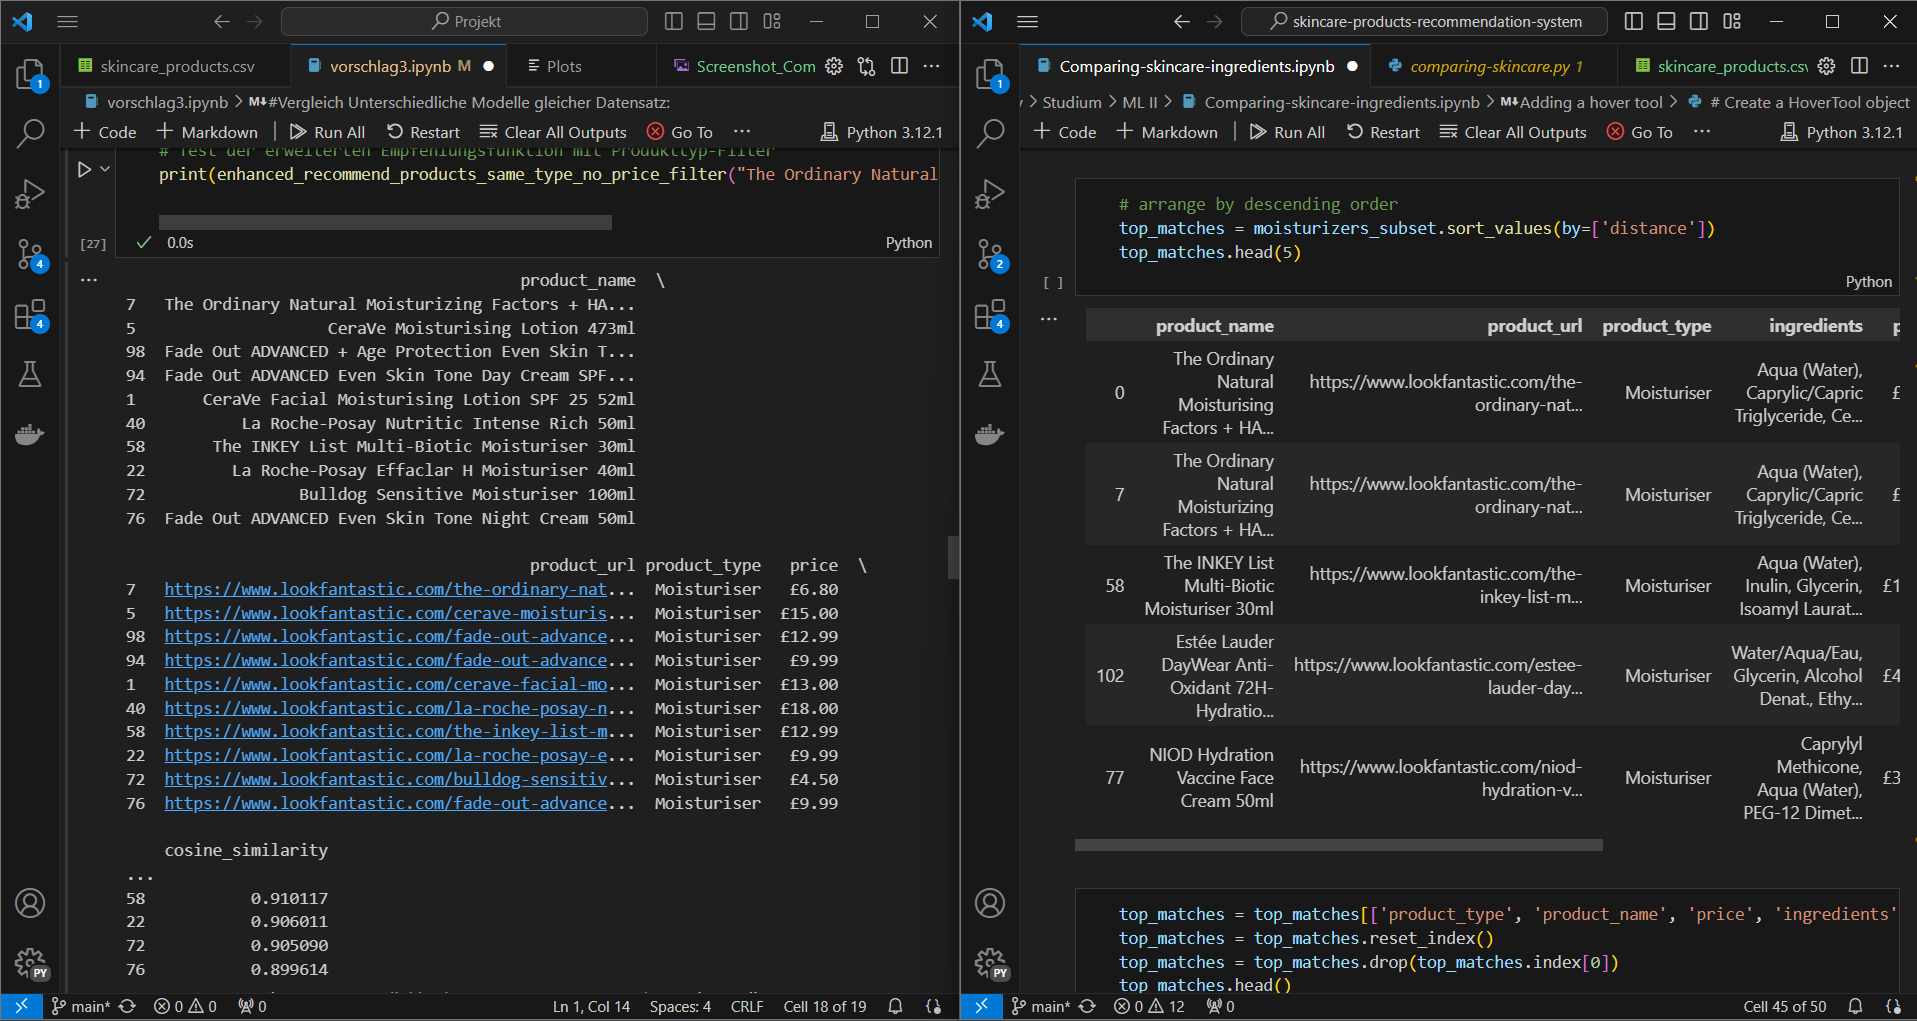

In [ ]:
from IPython.display import Image
Image(filename='Screenshot_Comparison Result.png')